In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv("transactions_graph.csv", sep=',')

In [ ]:
print(df.shape)

(594643, 5)


In [ ]:
print(df['fraud'].value_counts())

fraud
0    587443
1      7200
Name: count, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Source     594643 non-null  object 
 1   Target     594643 non-null  object 
 2   Weight     594643 non-null  float64
 3   typeTrans  594643 non-null  object 
 4   fraud      594643 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 22.7+ MB


**Nettoyage des doublons et valeurs manquantes**

In [ ]:
df = df.drop_duplicates()
df = df.dropna()

**Nettoyage et encodage de la variable typeTrans**

In [ ]:
df['typeTrans'] = df['typeTrans'].str.replace('"', '').str.replace("'", '').str.strip()

In [ ]:
le = LabelEncoder()
df['typeTrans'] = le.fit_transform(df['typeTrans'])

In [ ]:
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("typeTrans mapping:", mapping)
print(df[['typeTrans']].head(20))

typeTrans mapping: {'es_barsandrestaurants': np.int64(0), 'es_contents': np.int64(1), 'es_fashion': np.int64(2), 'es_food': np.int64(3), 'es_health': np.int64(4), 'es_home': np.int64(5), 'es_hotelservices': np.int64(6), 'es_hyper': np.int64(7), 'es_leisure': np.int64(8), 'es_otherservices': np.int64(9), 'es_sportsandtoys': np.int64(10), 'es_tech': np.int64(11), 'es_transportation': np.int64(12), 'es_travel': np.int64(13), 'es_wellnessandbeauty': np.int64(14)}
    typeTrans
0          12
1          12
2          12
3          12
4          12
5          12
6          12
7          12
8          12
9          12
10         12
11         12
12          4
13         12
14         12
15         12
16         12
17         12
18         12
19         12


In [ ]:
le_source = LabelEncoder()
df['Source'] = le_source.fit_transform(df['Source'])

le_target = LabelEncoder()
df['Target'] = le_target.fit_transform(df['Target'])

In [ ]:
df

,Source,Target,Weight,typeTrans,fraud
0,210,30,4.55,12,0
1,2753,30,39.68,12,0
2,2285,18,26.89,12,0
3,1650,30,17.25,12,0
4,3585,30,35.72,12,0
...,...,...,...,...,...
594638,1639,18,20.53,12,0
594639,3369,18,50.73,12,0
594640,529,31,22.44,2,0
594641,1083,18,14.46,12,0


**Cluster-based undersampling (équilibrage du dataset)**

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
# Separate majority class (fraud=0)
X_majority = df[df['fraud'] == 0].drop('fraud', axis=1)

In [ ]:
# Choose number of clusters (number of majority rows you want to keep)
n_clusters = 10_000  # adjust based on memory

**Applique MiniBatchKMeans pour regrouper ces données massives en 10 000 clusters (plus léger que le dataset complet).**

In [ ]:
# MiniBatchKMeans for large datasets
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=20000)
kmeans.fit(X_majority)

MiniBatchKMeans(batch_size=20000, n_clusters=10000, random_state=42)

Sélectionner le point le plus proche du centre de chaque cluster (représentatif).
Conserver ainsi 10 000 exemples non frauduleux au lieu de millions.

In [ ]:
import numpy as np

# Keep rows closest to cluster centers
closest_indices = []
for i in range(n_clusters):
    cluster_points = np.where(kmeans.labels_ == i)[0]
    center = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(X_majority.iloc[cluster_points] - center, axis=1)
    closest_idx = cluster_points[np.argmin(distances)]
    closest_indices.append(closest_idx)

In [ ]:
# Reduced majority dataset
X_majority_reduced = X_majority.iloc[closest_indices]
y_majority_reduced = pd.Series([0]*len(closest_indices))

In [ ]:
print("Original majority size:", X_majority.shape[0])
print("Reduced majority size:", X_majority_reduced.shape[0])

Original majority size: 583415
Reduced majority size: 10000


In [ ]:
# Combine the reduced majority with its label
df_majority_reduced = X_majority_reduced.copy()
df_majority_reduced['fraud'] = y_majority_reduced.values

In [ ]:
# Concatenate with the minority class (fraud = 1) to get the final dataset
df_minority = df[df['fraud'] == 1]
df_balanced = pd.concat([df_majority_reduced, df_minority], axis=0).reset_index(drop=True)

In [ ]:
print("Final dataset shape:", df_balanced.shape)

Final dataset shape: (17200, 5)


In [ ]:
print(df_balanced['fraud'].value_counts())

fraud
0    10000
1     7200
Name: count, dtype: int64


**Application de Smote+Tomek Links(pour à la fois équilibrer et nettoyer le dataset)**

SMOTE permet de générer des exemples synthétiques de fraudes jusqu’à ce que le train set soit équilibré.

Tomek Links nettoie les frontières floues et doublons générés par SMOTE.


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek

Séparation des features et du label

In [ ]:
X = df_balanced.drop('fraud', axis=1)
y = df_balanced['fraud']

In [ ]:
print(y.value_counts())

fraud
0    10000
1     7200
Name: count, dtype: int64


In [ ]:
print(df_balanced.shape)

(17200, 5)


Split train set / test set

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

Train set size: 13760, Test set size: 3440


Appliquer SMOTE + Tomek Links sur le train set

In [ ]:
# Créer l'instance SMOTE + Tomek
smote_tomek = SMOTETomek(random_state=42)


In [ ]:
# Appliquer SMOTE + Tomek Links sur le train set uniquement
X_res, y_res = smote_tomek.fit_resample(X_train, Y_train)

In [ ]:
print(pd.Series(y_res).value_counts())

fraud
0    7600
1    7600
Name: count, dtype: int64


In [ ]:
#vérifier les shapes
print(f"Train set après SMOTE + Tomek : X_res = {X_res.shape}, y_res = {y_res.shape}")

Train set après SMOTE + Tomek : X_res = (15200, 4), y_res = (15200,)


# Construction du graphe
analyser des données sous forme de graphes

In [ ]:
import networkx as nx
import pandas as pd

In [ ]:
# Créer un graphe orienté
G = nx.DiGraph()

# Ajouter les arêtes
for idx, row in X_res.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight'])


**Calculer les centralités**

pour évaluer l’importance ou l’influence d’un nœud dans le réseau.

In [ ]:
# Degree centrality: Nombre de connexions d’un nœud.
degree_c = nx.degree_centrality(G)

In [ ]:
# Betweenness Centrality: Mesure combien un nœud sert de pont dans le réseau.
betweenness_c = nx.betweenness_centrality(G, weight='weight')

In [ ]:
# Closeness Centrality: Proximité d’un nœud à tous les autres.
closeness_c = nx.closeness_centrality(G)

In [ ]:
# Eigenvector Centrality: Importance d’un nœud selon l’importance de ses voisins
eigenvector_c = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06, weight='weight')

In [ ]:
# Ajouter les centralités du Source
X_res['degree_c'] = X_res['Source'].map(degree_c)
X_res['betweenness_c'] = X_res['Source'].map(betweenness_c)
X_res['closeness_c'] = X_res['Source'].map(closeness_c)
X_res['eigenvector_c'] = X_res['Source'].map(eigenvector_c)

In [ ]:
print(X_res.head())
print("Train set shape with graph features:", X_res.shape)

   Source  Target   Weight  typeTrans  degree_c  betweenness_c  closeness_c  \
0    3628      11    62.89          2  0.000785            0.0          0.0   
1    1628      40  1998.45         13  0.001569            0.0          0.0   
2    1415      18    22.64         12  0.001046            0.0          0.0   
3    3915      34  1191.55          4  0.001308            0.0          0.0   
4    4021      18    14.86         12  0.001046            0.0          0.0   

   eigenvector_c  
0   5.079191e-50  
1   5.079191e-50  
2   5.079191e-50  
3   5.079191e-50  
4   5.079191e-50  
Train set shape with graph features: (15200, 8)


**Resultat**

Pour un modèle ML classique, ce graphe est acceptable : les degree centralities peuvent déjà aider.

Ces nouvelles features permettent à un modèle ML classique (XGBoost, LightGBM) de repérer les fraudes en utilisant les relations du graphe, sans avoir besoin de GNN.

# Création du graphe sur le test set

In [ ]:
# Créer un graphe orienté pour le test set
G_test = nx.DiGraph()

# Ajouter les arêtes à partir du test set
for idx, row in X_test.iterrows():
    G_test.add_edge(row['Source'], row['Target'], weight=row['Weight'])

In [ ]:
degree_c_test = nx.degree_centrality(G_test)
betweenness_c_test = nx.betweenness_centrality(G_test, weight='Weight')
closeness_c_test = nx.closeness_centrality(G_test)
eigenvector_c_test = nx.eigenvector_centrality(G_test, max_iter=1000, tol=1e-06, weight='Weight')

In [ ]:
X_test['degree_c'] = X_test['Source'].map(degree_c_test)
X_test['betweenness_c'] = X_test['Source'].map(betweenness_c_test)
X_test['closeness_c'] = X_test['Source'].map(closeness_c_test)
X_test['eigenvector_c'] = X_test['Source'].map(eigenvector_c_test)

In [ ]:
print(X_test.head())
print("Train set shape with graph features:", X_test.shape)

       Source  Target  Weight  typeTrans  degree_c  betweenness_c  \
4330     1768      30   52.78         12  0.000485            0.0   
13818     615       2  203.08         14  0.005337            0.0   
7291      361      30   15.83         12  0.000970            0.0   
2872     3883      45   44.10          3  0.000485            0.0   
302      3385      18    4.23         12  0.000970            0.0   

       closeness_c  eigenvector_c  
4330           0.0   1.725347e-07  
13818          0.0   1.725347e-07  
7291           0.0   1.725347e-07  
2872           0.0   1.725347e-07  
302            0.0   1.725347e-07  
Train set shape with graph features: (3440, 8)


In [ ]:
print(nx.number_connected_components(G_test.to_undirected()))

1


le code renvoie 1 → tout le graphe test est connecté, top

# Modélisation (Random Forest)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt'
)

# Entraîner sur le train set avec features de centralité
rf.fit(X_res, y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [ ]:
# Prédiction sur le test set
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Évaluation
print(classification_report(Y_test, y_pred))
print("ROC AUC:", roc_auc_score(Y_test, y_proba))

cm = confusion_matrix(Y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2000
           1       0.94      0.98      0.96      1440

    accuracy                           0.97      3440
   macro avg       0.96      0.97      0.97      3440
weighted avg       0.97      0.97      0.97      3440

ROC AUC: 0.9957618055555555
[[1911   89]
 [  24 1416]]


 ce modèle Random Forest prédit très bien les transactions : précision et rappel élevés pour les deux classes, et un ROC-AUC de 0,996 indique une excellente capacité à distinguer les fraudes des non-fraudes.
La matrice de confusion montre peu d’erreurs : 89 faux négatifs et 24 faux positifs sur 3 440 transactions.

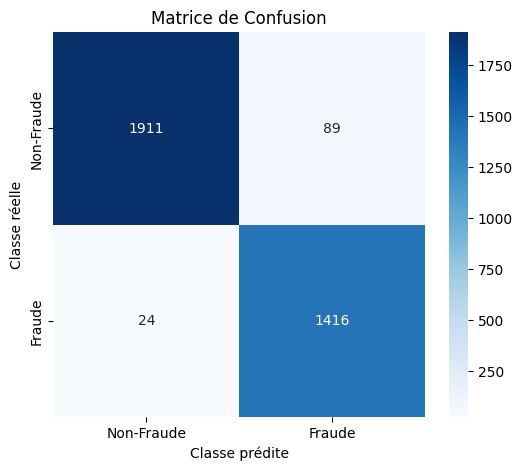

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions
y_pred = rf.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(Y_test, y_pred)

# Affichage avec seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraude','Fraude'], yticklabels=['Non-Fraude','Fraude'])
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.title('Matrice de Confusion')
plt.show()
